# Training to identify crossing points 

Author: Jose Miguel Serra Lleti

This notebook corresponds to the article: __________

_Please, cite the original paper if you make use of anything present in this notebook._

The following notebook describes how to train a convolutional neural network that identifies edges in an SEM image from a MatTek grid (and after that its center coordinates).

## Prepare libraries and dataset

For using tensorflow with GPU. If you see error messages in the jupyter console regarding your GPU and there is not a message our from the first cell, check that you have the right CUDA version installed: https://www.tensorflow.org/install/source#linux.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 
from shutil import copyfile
from tqdm import tqdm
import glob
import os
from keras import backend as K
from imp import reload
import tensorflow as tf


def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend
        
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:       
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf. config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Uncomment to see your list of available devices
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPU


 To adapt for differences in Brightness and Contrast and noise, it is recommended to preprocess the incoming tensors (a tensor is just a stack of images with the order N C H W (number of images, channels, height, width)). In addition, to have a range between 0 and 1 it also improves the accuracy of the trained network.The following functions will help on that, modified it at will (if needed):

In [3]:
### PREPROCESSING FUNCTION
import numpy as np
import cv2

iclahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(32, 32))
# All images are preprocessed for unbalanced brightness and contrast and resized to 256 by 256
def preprocess(image):   
    image = cv2.GaussianBlur(image,(5,5),0)  
    n_image = iclahe.apply(np.uint8(image))
    final = np.array(n_image,dtype=np.float32)
    final = (final-np.min(final))/(np.max(final)-np.min(final)) # Normalization has to be done AFTER AUGMENTATION
    return final

### Data structure

The data for training can be downloaded from :  https://drive.google.com/drive/folders/1bfr3UhgtXpTlzy2EsYPbQEN0Pt2xaheh?usp=sharing  and download the data set SEMcross_data.zip.

What do we need? 
 - Set of images from the crosses - from 30 to 100 recommended, the more the better
 - Set of images from the crosses segmented (same images, annotated)
 - If possible, for validation, the crossing center in pixel coordinates. This will be used in the notebook II.

Inside the folder data, it contains the data as it was coming from previous acquisitions using the FIB/SEM and CLEMSite software. The detection used in that moment was a Matlab algorithm (you can find it in the folder matlab_msite, with instructions in the README). However, it can be also a set of manual annotations, since the Matlab analytic solution contains many errors that need curation. The important parts that need to be provided are the following :
- data\\crosses
    - SCANxx - belonging to a sample, e.g. SCAN01  
        - Image of a crossing named as "ref"+ alpha numerical character + .tif, e.g. ref_0_5F_.tif
        - Folder named "cross_det_ref_" which contains:
            - A file "fpoints_pixels.csv" where coordinates of the center solution are given in the following format: 372,285,1  (x,y,1) in image coordinates. The coordinate is the center of the cross in the image.
            - A file "lines.tif", an RGB image where the solution of the edges to be detected is printed on top of the original images, in red. 
           

In [4]:
## Read information of crossings from data\\crosses
sample = {}
sample['origin'] = []
sample['target_point'] = []
sample['target_im']=[]

k=0
# Load data
dirSample = ".\\data\\crosses"
flist = glob.glob(dirSample + "\\*SCAN*")
flistdir= [f for f in flist if os.path.isdir(f)]
if flistdir is None:
        raise Exception('--scanfolder not found')

for sample_file in tqdm(flistdir):
    flist2 = glob.glob(sample_file + "\\*cross_det_ref_*\\*fpoints_pixels.csv*")
    for infile in flist2:
            letter = infile[-21:-19] 
            flist4 = glob.glob(sample_file +"\\*ref*_"+letter+"_*.tif")
            head,tail = os.path.split(infile)
            if flist4:
                    sample['target_point'].append(infile) 
                    sample['origin'].append(flist4[0])
                    sample['target_im'].append(head+"\\lines.tif")

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.47it/s]


 In preparation for the training, since later we are applying augmentation, the coordinate values have to be read from the files and provided together with the images. In addition, instead of using 512x512 images, the network takes 256x256 inputs, so we need to scale the images and coordinates accordingly, in this case, down by half.

In [5]:
import csv
y = np.empty((0,2))
f = 0.5 #scale from resolution to 256 to 256, in this case 256/512 = 0.5
for csvfile in sample['target_point']:
    with open(csvfile) as cs:
        readCSV = csv.reader(cs, delimiter=',')
        for row in readCSV:
            coords = row
        coords = [float(coords[0])*f,float(coords[1])*f]
        solution = np.array([coords[0],coords[1]],dtype=np.int32)
        y = np.vstack((y,solution))

Now that the data is loaded, we have to preprocess it and convert it to tensors. This is just a stacking of the images in a proper format for tensorflow.

Notice we take the red channel from the solution image provided and we made a mask of it.

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm
from skimage import data, io, filters
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split
from skimage.morphology import square
from skimage.filters.rank import mean_bilateral
from skimage.morphology import erosion, dilation

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))

# In our case, the segmentation is in red and the channel has to be extracted to generate a final
# binary image with the resulting segmentation
def path_to_tensor_targets(img_path):
    img = cv2.imread(img_path,3)
    lower = np.array([0, 0, 200])
    upper = np.array([0, 0, 255])
    black_mask = cv2.inRange(img, lower, upper)
    final = np.array(black_mask,dtype=np.float32)
    final = cv2.resize(black_mask,(256,256))
    final[final>0] = 1.0
    selem = square(3)
    final = dilation(final, selem)
    # convert 3D tensor to 4D tensor with shape (1, h, w, 1) and return 4D tensor    
    return np.expand_dims(final, axis=0)


def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    img = cv2.resize(img, (256, 256)) 
    # convert 3D tensor to 4D tensor with shape (1, h, w, 1) and return 4D tensor    
    return np.expand_dims(img, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def paths_to_tensor_targets(img_paths):
    list_of_tensors = [path_to_tensor_targets(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [7]:
len(sample['origin']) # We have a total of 600 images!

600

In [8]:
train_tensors = paths_to_tensor(sample['origin'])

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 295.74it/s]


In [9]:
target_tensors  = paths_to_tensor_targets(sample['target_im'])

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 104.95it/s]


In the following cell we are augmenting the data. That means, we modify the original data by:
   - Inverting LUT
   - Rotation between -40 and 40 degrees
   - Contrast change (multiply by a number between 0.9 and 1.3)
   - Flip in any direction
   - Affine transformation : rotation (-60,60), scaling from 0.7 to 1.2, shifting -0.2 and 0.2 and shearing -5,5
  
  The augmentation values were tested to avoid extremes which could confuse the detector. Image coordinates are also affected by the augmentations when involved geometrical transformations.

In [11]:
# IMAGE  AUGMENTATION
import imgaug as ia
from imgaug import augmenters as iaa

NUMBER_OF_OUTPUTS_PER_IMAGE = 8

ia.seed(5)

# Amplify train_tensors
list_of_images = []
list_of_targets = []
list_of_y = []

for i in range (NUMBER_OF_OUTPUTS_PER_IMAGE):
    for ind,tensor in enumerate(train_tensors):
        img_or = train_tensors[ind,:,:]   
        img_tar = target_tensors[ind,:,:]
        keypoints = ia.KeypointsOnImage([ia.Keypoint(x=y[ind][0], y=y[ind][1])], shape=img_or.shape)

        seq_or = iaa.Sometimes(0.5,[
            # CAREFUL with augmentations that affect binary images. 
            iaa.Invert(1.0), # change brightness
            iaa.Add((-40,40)), # 
            iaa.Multiply((0.9,1.3))])
        
        seq = iaa.SomeOf(2,[
            iaa.Fliplr(1.0), # horizontal flips
            iaa.Flipud(1.0),# vertical flips
            iaa.Affine(rotate=(-60,60),scale=(0.7, 1.2), translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},shear=(-5, 5))])

        seq_det = seq.to_deterministic()

        # Augment keypoints and images.
        image_aug = seq_or.augment_images([img_or])[0] # careful here, first augment inversions and b&c changes
        image_aug = seq_det.augment_images([image_aug])[0]        
        y_image_aug = seq_det.augment_images([img_tar])[0]
        keypoints_aug = seq_det.augment_keypoints([keypoints])[0]
        after = keypoints_aug.keypoints[0]
        ntensor = np.expand_dims(image_aug, axis=0)
        y_ntensor = np.expand_dims(y_image_aug, axis=0)
        list_of_images.append(ntensor)
        list_of_targets.append(y_ntensor)
        list_of_y.append(np.array([after.x,after.y]))


In [10]:
f_train = np.vstack(list_of_images)
fy_train = np.vstack(list_of_y)
f_target = np.vstack(list_of_targets)

In [11]:
train_tensors = np.vstack([train_tensors,f_train])
y = np.vstack([y,fy_train])
target_tensors = np.vstack([target_tensors,f_target])

In [12]:
# Shuffle the tensors
import random
indexes = list(range(len(train_tensors)))
random.shuffle(indexes)
f_train_tensors = np.array([ preprocess(train_tensors[i]) for i in indexes])
f_target_tensors = np.array([ target_tensors[i] for i in indexes])

Now we can visualize some of the images after augmentation. 

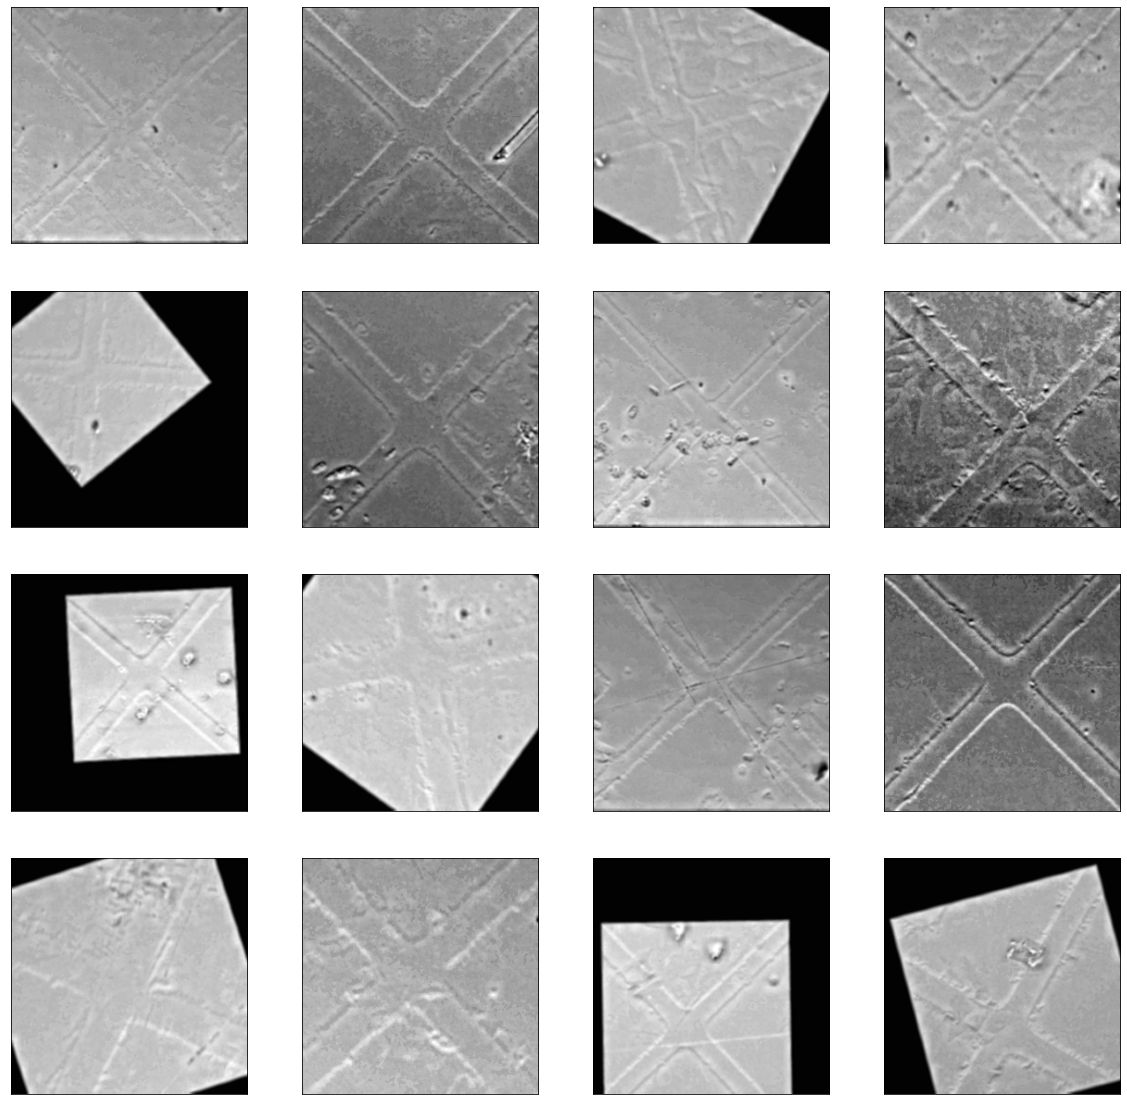

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

fig = plt.figure(figsize=(20,20))
for i in range(16):
    ix = i+500
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = f_train_tensors[ix,:,:]*255
    ax.imshow(np.squeeze(np.array(img,dtype=np.uint8)),cmap='gray')
    

And its solutions... We managed to augment from 600 images to 4800 (1 image to 8, by including mixture of transformations to each image)! In this dataset, it was not healthy to go beyond a factor of 8 augmentations per image. We are close to hit the overfitting limit with this number.

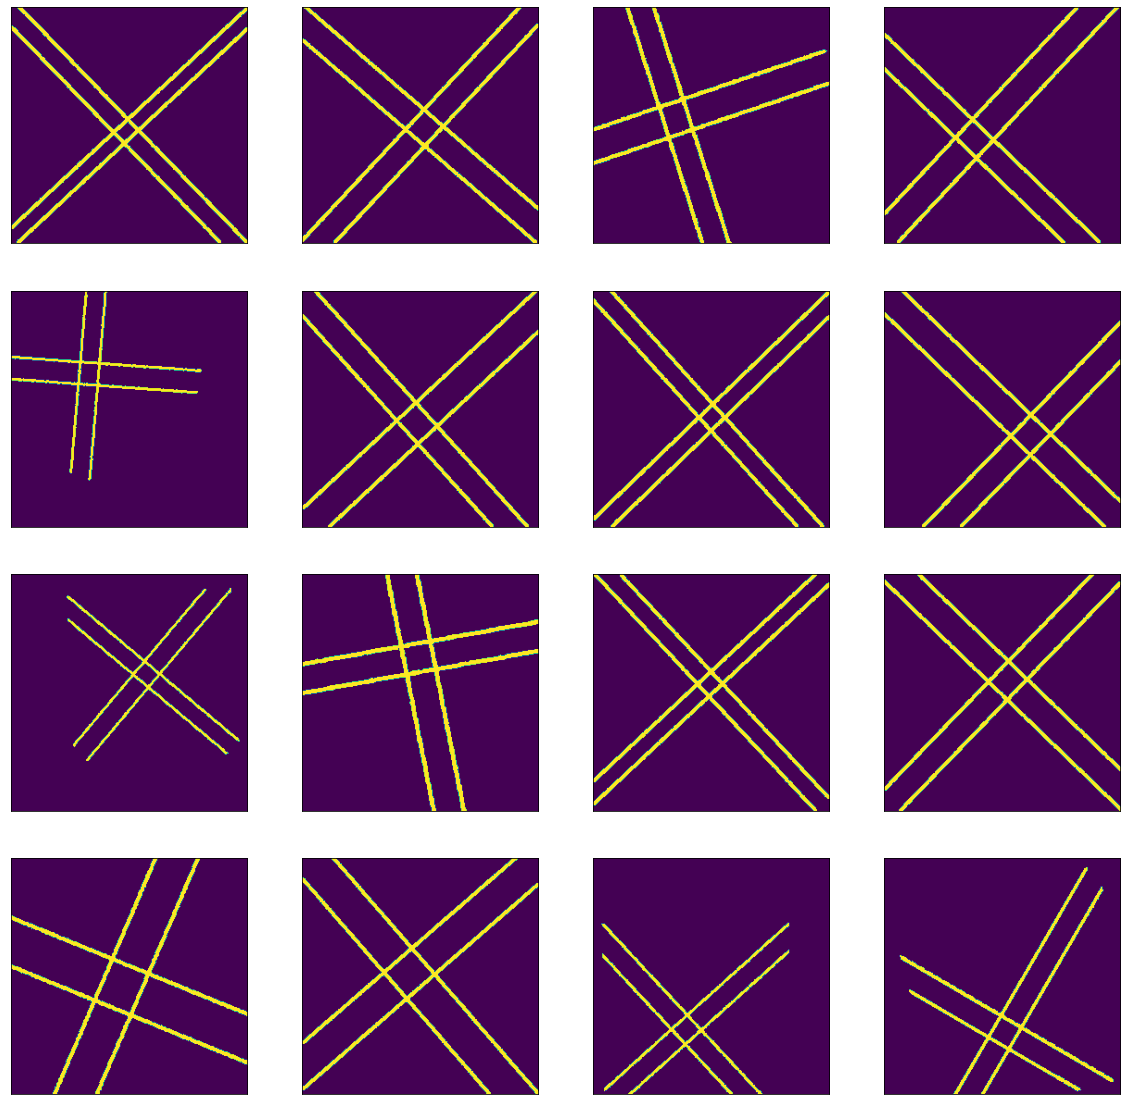

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

fig = plt.figure(figsize=(20,20))
for i in range(16):
    ix = i+500
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = f_target_tensors[ix,:,:]
    ax.imshow(np.squeeze(img>0))

In [15]:
# This function can be used for later validation
x_train, x_test, y_train, y_test = train_test_split(f_train_tensors, f_target_tensors , test_size=0.05, random_state=1)
_, x_test2, _, y_test2 = train_test_split(f_train_tensors, y , test_size=0.05, random_state=567)

In [16]:
x_train = np.expand_dims(x_train, axis=3)
y_train =  np.expand_dims(y_train, axis=3)

Given the small amount of data available, it is not recommended to use deep architectures like ResNet or DenseNet. A simple Unet with three levels (https://arxiv.org/abs/1505.04597) based in VGG-16 will do the trick. You are free to change or modify to a more advanced architecture. 

The loss function used will be binary cross-entropy (simply if the mask predicted matches or not).

In [17]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization,GlobalAveragePooling2D
from keras.layers import Flatten, Dense

In [18]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout,concatenate, Conv2DTranspose
from keras.models import Model

inputs = Input((256, 256, 1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D((2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         batch_normalization_1[0][0]      
____________________________________________________________________________________________

Now, the model is trained. In this case we observed that around 50 epochs there was already convergence. We used early stopping to stop the model for training after 25 minutes.

Note: This was trained with a computer with one GPU 8 Gb memory Nvidia RTX 2070. Verify that you installed tensorflow gpu (at 2.0 currently) and that NVIDIA CUDA is installed (with cudann 64 bits 7 and Cuda Toolkit v 10.1). It also can be trained by CPU but it will take 10 times more.

In [19]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
##  Compile the model
optim = Adam(lr = 1e-4)
model.compile(optimizer=optim, loss='binary_crossentropy')
 
## TODO: Train the model
checkpointer = ModelCheckpoint(filepath='weights.model_CROSS_DETECTOR.hdf5', 
                               verbose=1, save_best_only=True)

earlystopper = EarlyStopping(patience=12, verbose=0)

hist = model.fit(
        x_train, y_train,      
        validation_split=0.1,
        #validation_data = (valid_tensors,y_valid), another way to provide validation data
        batch_size =24,
        epochs=150,
        verbose =2,
        callbacks = [earlystopper, checkpointer])

Train on 4617 samples, validate on 513 samples
Epoch 1/150
 - 37s - loss: 0.7058 - val_loss: 0.6946

Epoch 00001: val_loss improved from inf to 0.69459, saving model to weights.model_CROSS_DETECTOR.hdf5
Epoch 2/150
 - 30s - loss: 0.6410 - val_loss: 0.6563

Epoch 00002: val_loss improved from 0.69459 to 0.65633, saving model to weights.model_CROSS_DETECTOR.hdf5
Epoch 3/150
 - 30s - loss: 0.5981 - val_loss: 0.5451

Epoch 00003: val_loss improved from 0.65633 to 0.54514, saving model to weights.model_CROSS_DETECTOR.hdf5
Epoch 4/150
 - 30s - loss: 0.5531 - val_loss: 0.5108

Epoch 00004: val_loss improved from 0.54514 to 0.51077, saving model to weights.model_CROSS_DETECTOR.hdf5
Epoch 5/150
 - 30s - loss: 0.5128 - val_loss: 0.4858

Epoch 00005: val_loss improved from 0.51077 to 0.48578, saving model to weights.model_CROSS_DETECTOR.hdf5
Epoch 6/150
 - 30s - loss: 0.4750 - val_loss: 0.4594

Epoch 00006: val_loss improved from 0.48578 to 0.45941, saving model to weights.model_CROSS_DETECTOR.hd

In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("model_CROSS_DETECTOR.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")

Saved model to disk


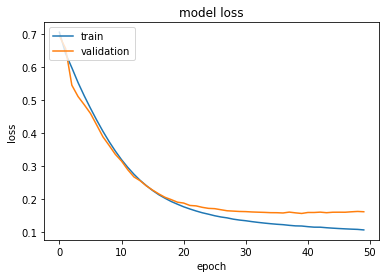

In [24]:
## TODO: Visualize the training and validation loss of your neural network
def plot_learning_curve(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./loss_curve.png')


plot_learning_curve(hist)
#img = cv2.imread('./accuracy_curve.png')

Finally, let's test that loading our model works and can be used to predict the edges of the crossings.

In [25]:
# load the weights that yielded the best validation accuracy
model.load_weights('weights.model_CROSS_DETECTOR.hdf5')

In [26]:
# Get some test images (reserved before).
x_test = np.squeeze(x_test[0:53])
x_test =  np.expand_dims(x_test, axis=3)
x_test.shape

(53, 256, 256, 1)

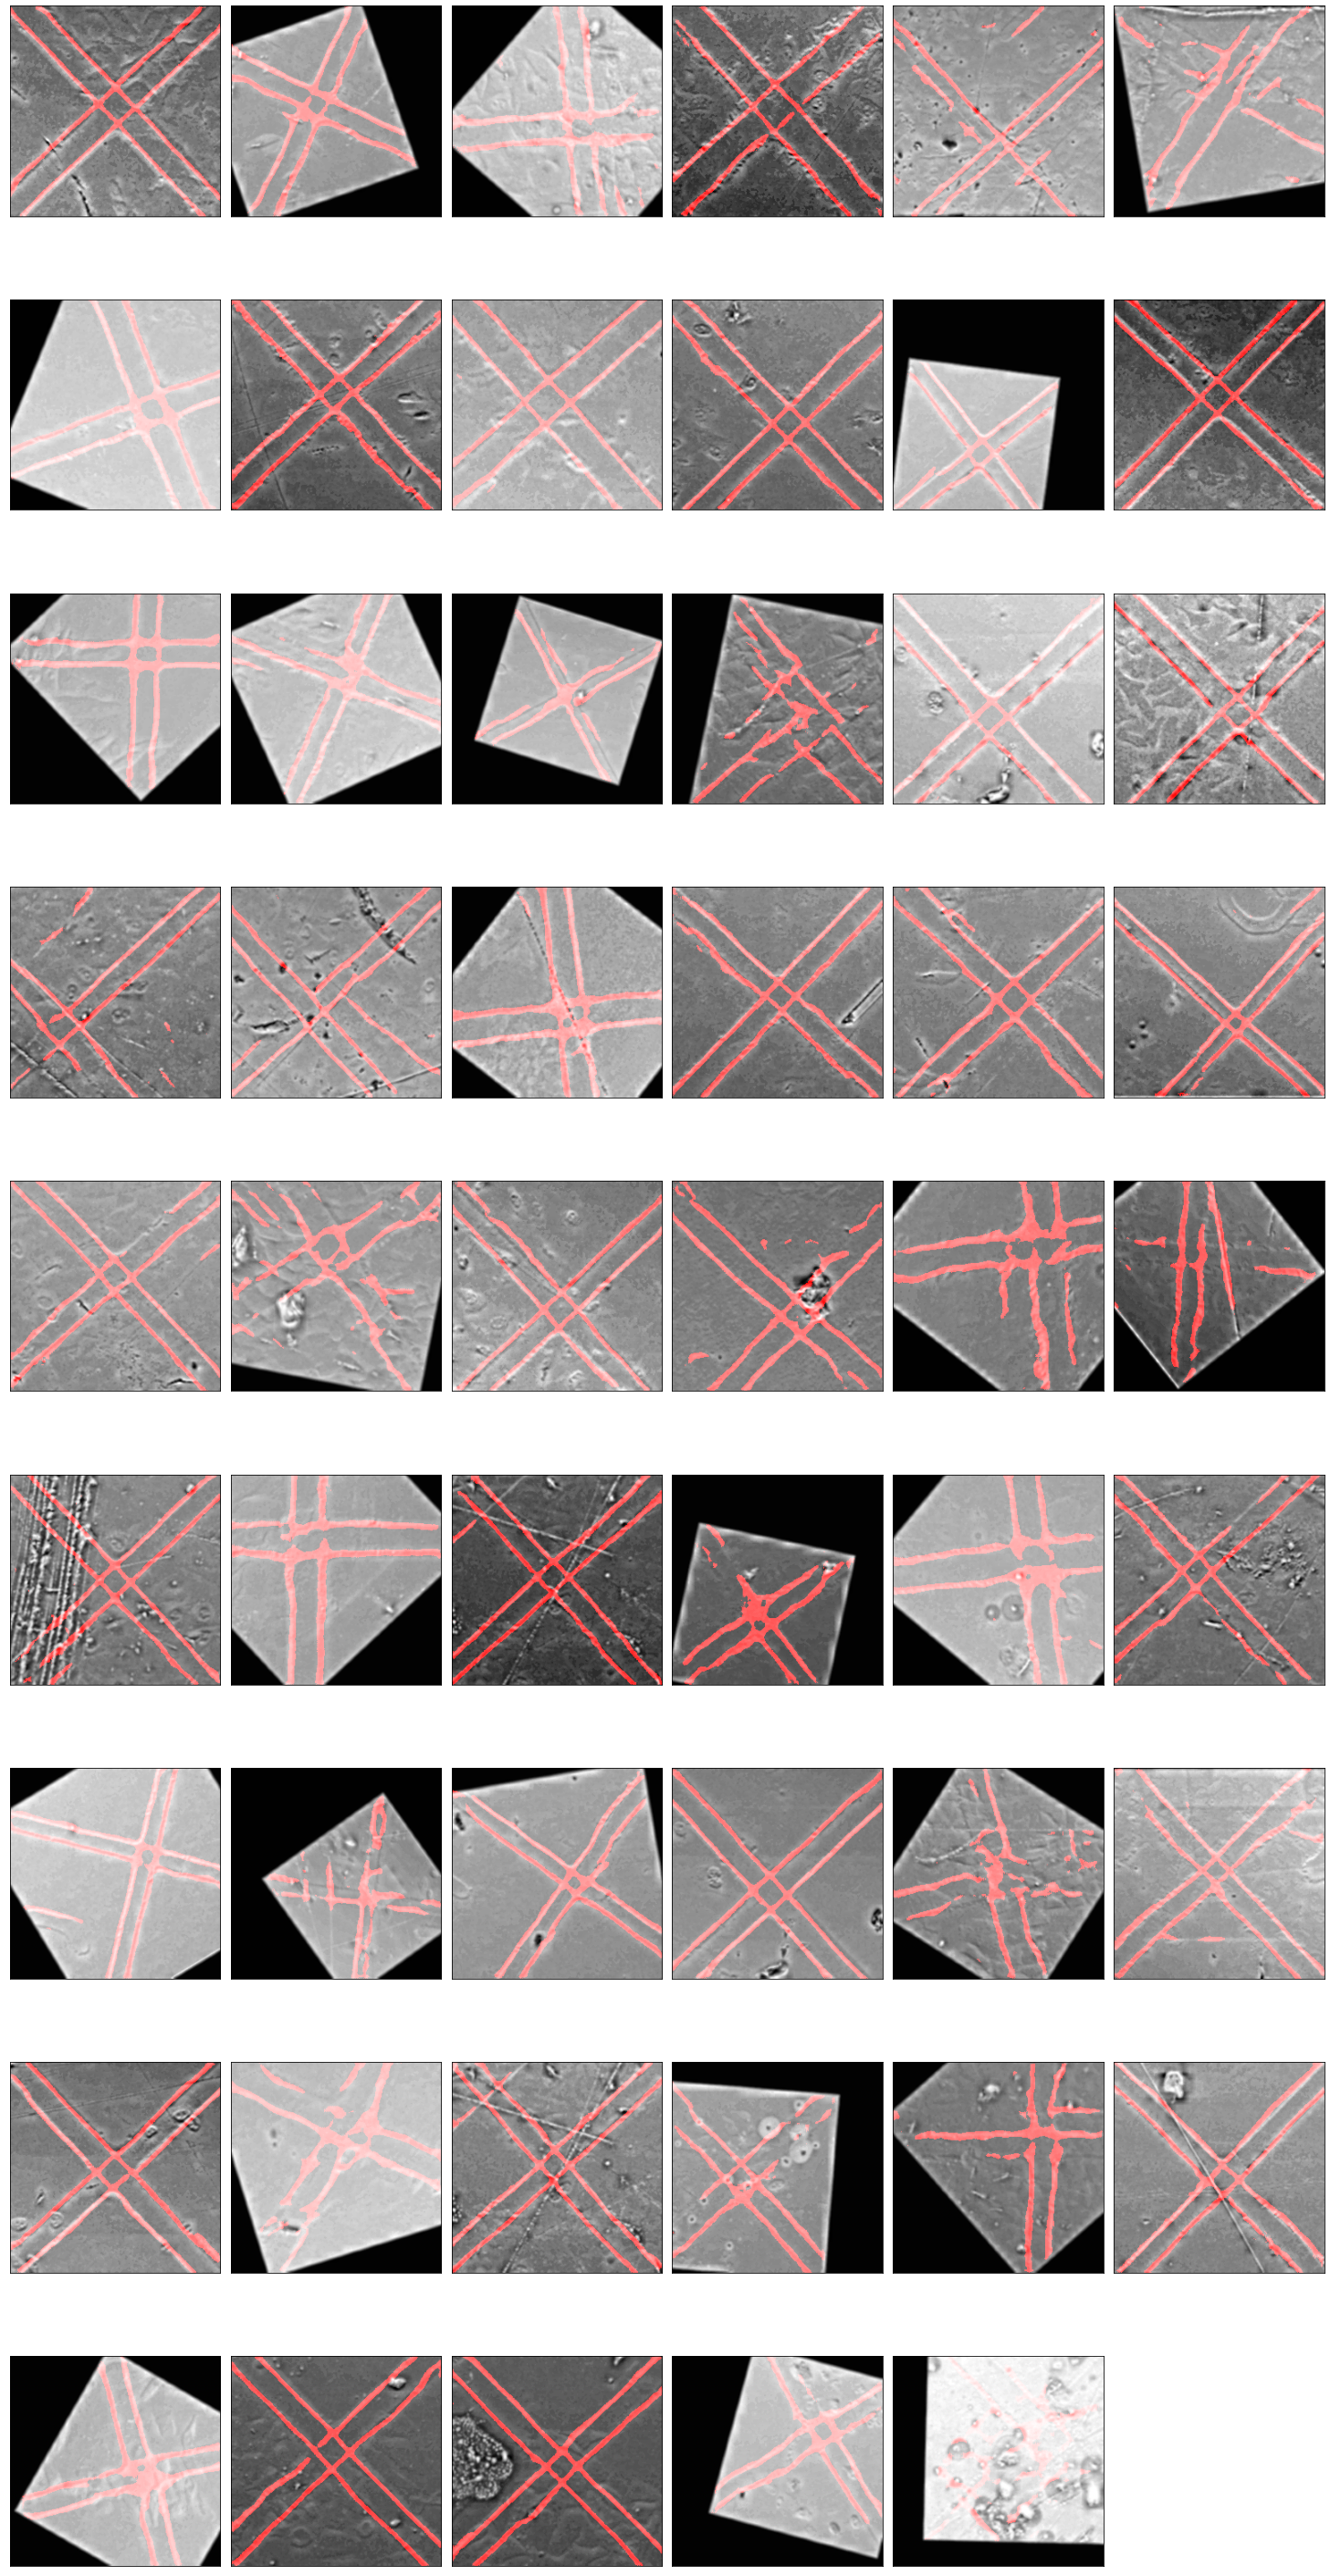

In [27]:
# Prediction
y_t = model.predict(x_test)

# Plot the result for the N images from the test
fig = plt.figure(figsize=(20,40))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(y_t)):
    ax = fig.add_subplot(9, 6, i + 1, xticks=[], yticks=[])
    img = np.zeros((256,256,3),dtype = np.uint8)
    img[:,:,:]= x_test[i]*255
    im1 = img[:,:,0]
    im1[np.squeeze(y_t[i,:,:]>0.2)] = 255
    img[:,:,0] = im1
    #im2[:,:,1] = np.min([y_test[i]*255,img[:,:,2]])
    ax.imshow(np.squeeze(img))

Continues in CROSS DETECTOR UNET PART II 